Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu)$$ 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt


2025-02-08 20:16:36.219323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 20:16:38.251292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
saved_data='./cached_data/'

In [3]:
training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
preselection_score = np.load(f"{saved_data}preselection_score.npy")
weights = np.load(f"{saved_data}weights.npy")

In [4]:
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
dataset = pd.DataFrame(training_features, columns=columns)


In [5]:
preselection_score[train_labels==1].shape

(436311,)

In [6]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [7]:
min_pred = np.amin(preselection_score)
max_pred = np.amax(preselection_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(preselection_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

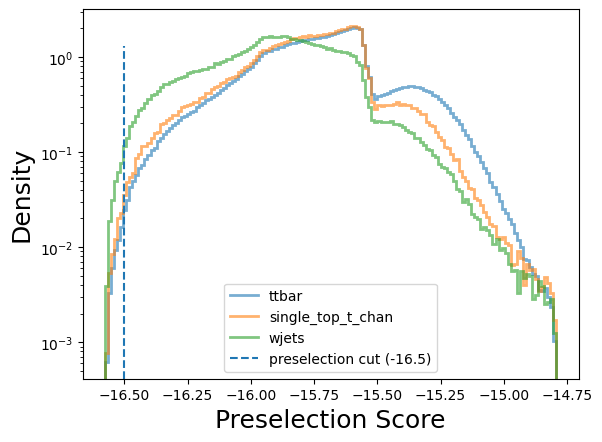

In [8]:
preselection_cut = -16.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [75]:
# Make the preselections

training_features = training_features[preselection_score>=preselection_cut].copy()
train_labels = train_labels[preselection_score>=preselection_cut].copy()
weights = weights[preselection_score>=preselection_cut].copy()

preselection_score_selected = preselection_score[preselection_score>=preselection_cut].copy()


In [ ]:
class TrainEvaluate_NN:

    def __init__(self, dataset, weights, train_labels, columns, columns_scaling, 
                rnd_seed, sample_name, output_dir, output_name, path_to_figures='',
                     path_to_models='', path_to_ratios='',
                     use_log_loss=False, split_using_fold=False):

        self.dataset = dataset
        self.weights = weights
        self.train_labels = train_labels
        self.columns = columns
        self.columns_scaling = columns_scaling
        self.random_state_holdout = rnd_seed
        self.sample_name = sample_name
        self.output_dir = output_dir
        self.output_name = output_name
        self.path_to_figures = path_to_figures
        self.path_to_models = path_to_models

        self.path_to_ratios=path_to_ratios
        self.use_log_loss = use_log_loss
        self.split_using_fold = split_using_fold
        

    def train(self, hidden_layers, neurons, number_of_epochs, batch_size,
             learning_rate, scalerType, calibration=False, 
             num_bins_cal = 40, callback = True, 
             callback_patience=30, callback_factor=0.01,
             activation='swish'):

        self.calibration = calibration
        self.batch_size = batch_size

        #HyperParameters for the NN training
        holdout_num=math.floor(self.features.shape[0]*0.2)
        train_num=math.floor(self.features.shape[0]*0.8)
        validation_split = 0.1

        data_train, data_holdout, \
        label_train, label_holdout, \
        weight_train, weight_holdout = train_test_split(self.dataset[self.columns], 
                                                        self.train_labels, 
                                                        self.weights, 
                                                        test_size=holdout_num, 
                                                        random_state=self.random_state_holdout,
                                                        stratify=self.train_class)



        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=callback_factor,
                                        patience=callback_patience, min_lr=0.000000001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=300)


        if (scalerType == 'MinMax'):
            self.scaler = ColumnTransformer([("scaler1",MinMaxScaler(feature_range=(-1.5,1.5)), self.columns_scaling)],remainder='passthrough')
        if (scalerType == 'StandardScaler'):
            self.scaler = ColumnTransformer([("scaler1",StandardScaler(), self.columns_scaling)],remainder='passthrough')
        if (scalerType == 'PowerTransform_Yeo'):
            self.scaler = ColumnTransformer([("scaler1",PowerTransformer(method='yeo-johnson', standardize=True), self.columns_scaling)],remainder='passthrough')
        if (scalerType == 'RobustScaler'):
            self.scaler = ColumnTransformer([("scaler1",RobustScaler(unit_variance=True), self.columns_scaling)],remainder='passthrough')
        if (scalerType == 'QuantileTransformer'):
            self.scaler = ColumnTransformer([("scaler1",QuantileTransformer(output_distribution='normal'), self.columns_scaling)],remainder='passthrough')


        scaled_data_train = self.scaler.fit_transform(data_train)
        scaled_data_train= pd.DataFrame(scaled_data_train, columns=self.columns)

        scaled_data_holdout = self.scaler.transform(data_holdout)
        scaled_data_holdout = pd.DataFrame(scaled_data_holdout, columns=self.columns)

        # Check if the datasets are normalized
        print(f"Sum of weights of class 0: {np.sum(weight_train[label_train==0])}")
        print(f"Sum of weights of class 1: {np.sum(weight_train[label_train==1])}")

        print(f"Using {activation} activation function")

        self.model_NN = build_model(n_hidden=hidden_layers, n_neurons=neurons, 
                                    learning_rate=learning_rate, 
                                    input_shape=[len(self.columns)], 
                                    use_log_loss=self.use_log_loss,
                                    activation=activation)

        self.model_NN.summary()

        if callback:

            print("Using Callbacks")

            self.history = self.model_NN.fit(scaled_data_train, label_train, callbacks=[reduce_lr, es], 
                                                epochs=number_of_epochs, batch_size=batch_size, 
                                                validation_split=validation_split, sample_weight=weight_train, 
                                                verbose=2)

        else:
            print("Nor Using Callbacks - Systematic Uncertainties?")

            self.history = self.model_NN.fit(scaled_data_train, label_train, 
                                                epochs=number_of_epochs, batch_size=batch_size, 
                                                validation_split=validation_split, sample_weight=weight_train, 
                                                verbose=2)
        

        print("Finished Training")


        saved_scaler = self.path_to_models+"model_scaler.bin"
        print(saved_scaler)

        model_json = self.model_NN.to_json()
        with open(self.path_to_models+"model_arch.json", "w") as json_file:
            json_file.write(model_json)

        # serialize weights to HDF5
        self.model_NN.save_weights(self.path_to_models+"model_weights.h5")

        dump(self.scaler, saved_scaler, compress=True)

        plot_loss(self.history, path_to_figures=self.path_to_figures)

        # Redo the split with all the columns in the original dataset
        self.train_data_eval, self.train_holdout_eval = train_test_split(self.dataset, 
                                                                  test_size=holdout_num, 
                                                                  random_state=self.random_state_holdout,
                                                                  stratify=self.train_class)
        
        
        
        self.label_0_hpred = self.predict_with_model(self.train_holdout_eval[label_holdout==0], use_log_loss=self.use_log_loss)
        self.label_1_hpred = self.predict_with_model(self.train_holdout_eval[label_holdout==1], use_log_loss=self.use_log_loss)

        self.label_0_tpred = self.predict_with_model(self.train_data_eval[label_holdout==0], use_log_loss=self.use_log_loss)
        self.label_1_tpred = self.predict_with_model(self.train_data_eval[label_holdout==1], use_log_loss=self.use_log_loss)
        

        # Some diagnostics to ensure numerical stability
        print("Label 0 training data prediction (max) = "+str(np.amax(self.label_0_tpred)))
        print("Label 0 training data prediction (min) = "+str(np.amin(self.label_0_tpred)))

        print("Label 1 training data prediction (max) = "+str(np.amax(self.label_1_tpred)))
        print("Label 1 training data prediction (min) = "+str(np.amin(self.label_1_tpred)))

        print("Label 0 training data prediction (max) = "+str(np.amax(self.label_0_hpred)))
        print("Label 0 training data prediction (min) = "+str(np.amin(self.label_0_hpred)))

        print("Label 1 training data prediction (max) = "+str(np.amax(self.label_1_hpred)))
        print("Label 1 training data prediction (min) = "+str(np.amin(self.label_1_hpred)))




def build_model(n_hidden=4, n_neurons=1000, learning_rate=0.1, 
                input_shape=[11], use_log_loss=False, optimizer_choice='Nadam', 
                activation='swish'):
    
    model = tf.keras.models.Sequential()
    options = {"input_shape":input_shape}
    for layer in range(n_hidden):

        if activation=='mish':
            def mish(inputs):
                x = tf.nn.softplus(inputs)
                x = tf.nn.tanh(x)
                x = tf.multiply(x, inputs)
                return x

            model.add(Dense(n_neurons, activation=mish, **options))
        else:
            model.add(Dense(n_neurons, activation=activation, **options))
        options={}

    if not use_log_loss:
        model.add(Dense(1,activation='sigmoid',**options))
    else:
        model.add(Dense(1,activation='linear',**options))

    if optimizer_choice=='Nadam':
        optimizer = tf.keras.optimizers.Nadam(lr=learning_rate) 
    elif optimizer_choice=='Adam':
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate) 

    if use_log_loss:
        model.compile(loss=CARL_mod, optimizer=optimizer,weighted_metrics=['binary_accuracy'])
    else:
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer,weighted_metrics=['binary_accuracy'])
    return model

#The modified CARL loss that directly regresses to LLR
def CARL_mod(s_truth, s_predicted): 

    loss = (s_truth)*tf.exp(-0.5*s_predicted)+(1.0-s_truth)*tf.exp(0.5*s_predicted)
    return loss
